# Homework week 8

The purpose of this notebook is to do the Statistical Rethinking 2022 [homework](https://github.com/rmcelreath/stat_rethinking_2022/tree/main/homework) using Python.

In [42]:
import arviz as az
import daft
from causalgraphicalmodels import CausalGraphicalModel
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
from scipy.special import expit
import seaborn as sns
import statsmodels.api as sm

<IPython.core.display.Javascript object>

In [3]:
%load_ext nb_black
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

<IPython.core.display.Javascript object>

In [4]:
def standardize(x):
    x = (x - np.mean(x)) / np.std(x)
    return x

<IPython.core.display.Javascript object>

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


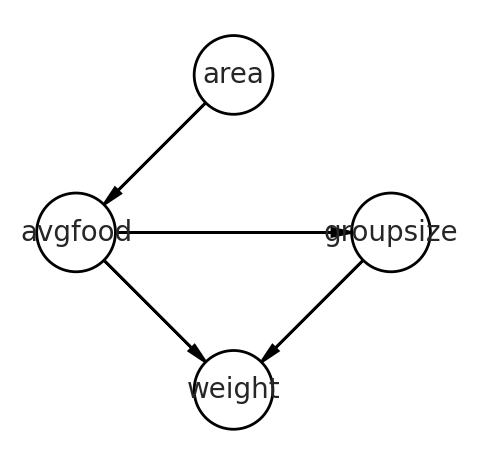

<IPython.core.display.Javascript object>

In [5]:
dag = CausalGraphicalModel(
    nodes=["area", "avgfood", "groupsize", "weight"],
    edges=[
        ("area", "avgfood"),
        ("avgfood", "groupsize"),
        ("avgfood", "weight"),
        ("groupsize", "weight"),
    ],
)
pgm = daft.PGM()
coordinates = {
    "area": (1, 1),
    "avgfood": (0, 0),
    "groupsize": (2, 0),
    "weight": (1, -1),
}
for node in dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag.dag.edges:
    pgm.add_edge(*edge)
pgm.render()

The data in week08_Monks.csv (found on the course website) are “like” and
“dislike” nominations by 18 monks living in the same monastery over three time
periods. Therefore the observed variables are counts from 0 to 3 of times monk A
nominated monk B as liked or disliked.1 Each row in the data is a pair of monks (a
dyad). The variables are:
- A: Index number for first monk in dyad
- B: Index number for second monk in dyad
- like_AB: Number of times A nominated B as liked
- like_BA: Number of times B nominated A as liked
- dislike_AB: Number of times A nominated B as disliked
- dislike_BA: Number of times B nominated A as disliked

# Q1

Use these data to estimate the amount of reciprocity in “like” nominations within dyads. You can ignore the “dislike” data for now. Use the social network example from the book to help, but you should modify it appropriately.

## Answer

yyyyyyy


Markdown/Latex for system of equations
$$ F \sim \text{Normal}(\mu, \sigma) $$
$$ \mu = \alpha + \beta_A A $$
$$ \alpha \sim \text{Normal}(0, 1) $$
$$ \beta_{A} \sim \text{Normal}(0, 3) $$
$$ \sigma \sim \text{Exp}(1) $$

In [7]:
# input data
DATA_DIR = '/Users/blacar/Documents/ds_projects/stats_rethinking/pymc3_ed_resources/resources/Rethinking_2/End_of_chapter_problems/data/'
df_monks = pd.read_csv(DATA_DIR + "week08_Monks.csv", sep=",", header=0)
df_monks.head()

,dyad_id,A,B,like_AB,like_BA,dislike_AB,dislike_BA,A_name,B_name
0,1,1,2,0,3,0,0,ROMUL,BONAVEN
1,2,1,3,3,3,0,0,ROMUL,AMBROSE
2,3,1,4,0,0,0,0,ROMUL,BERTH
3,4,1,5,0,0,0,0,ROMUL,PETER
4,5,1,6,0,0,0,0,ROMUL,LOUIS


<IPython.core.display.Javascript object>

In [8]:
# standardize variables
df['area_std'] = standardize(df['area'])
df.head()

,group,avgfood,groupsize,area,weight,area_std
0,1,0.37,2,1.09,5.02,-2.249313
1,1,0.37,2,1.09,2.84,-2.249313
2,2,0.53,2,2.05,5.33,-1.210738
3,2,0.53,2,2.05,6.07,-1.210738
4,3,0.49,2,2.12,5.85,-1.135008


<IPython.core.display.Javascript object>

In [8]:
# write model
with pm.Model() as mq1:

    # Priors are variables a, b, sigma (all stochastic)
    a = pm.Normal("a", mu=0, sd=1)
    bA = pm.Normal("bA", mu=0, sd=1)
    sigma = pm.Exponential("sigma", 1)

    # linear model (mu is deterministic)
    mu = a + bA * df['area_std']

    # likelihood
    f = pm.Normal("f", mu=mu, sd=sigma, observed=df['avgfood_std'])

    # prior predictive simulation
    prior_checks = pm.sample_prior_predictive(samples=200)

    # generate posterior and sample
    idata_mq1 = pm.sample(1000, tune=1000, return_inferencedata=True, progressbar=False)

    # posterior predictive simulation
    posterior_checks = pm.sample_prior_predictive(samples=200)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bA, a]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Prior predictive checks')

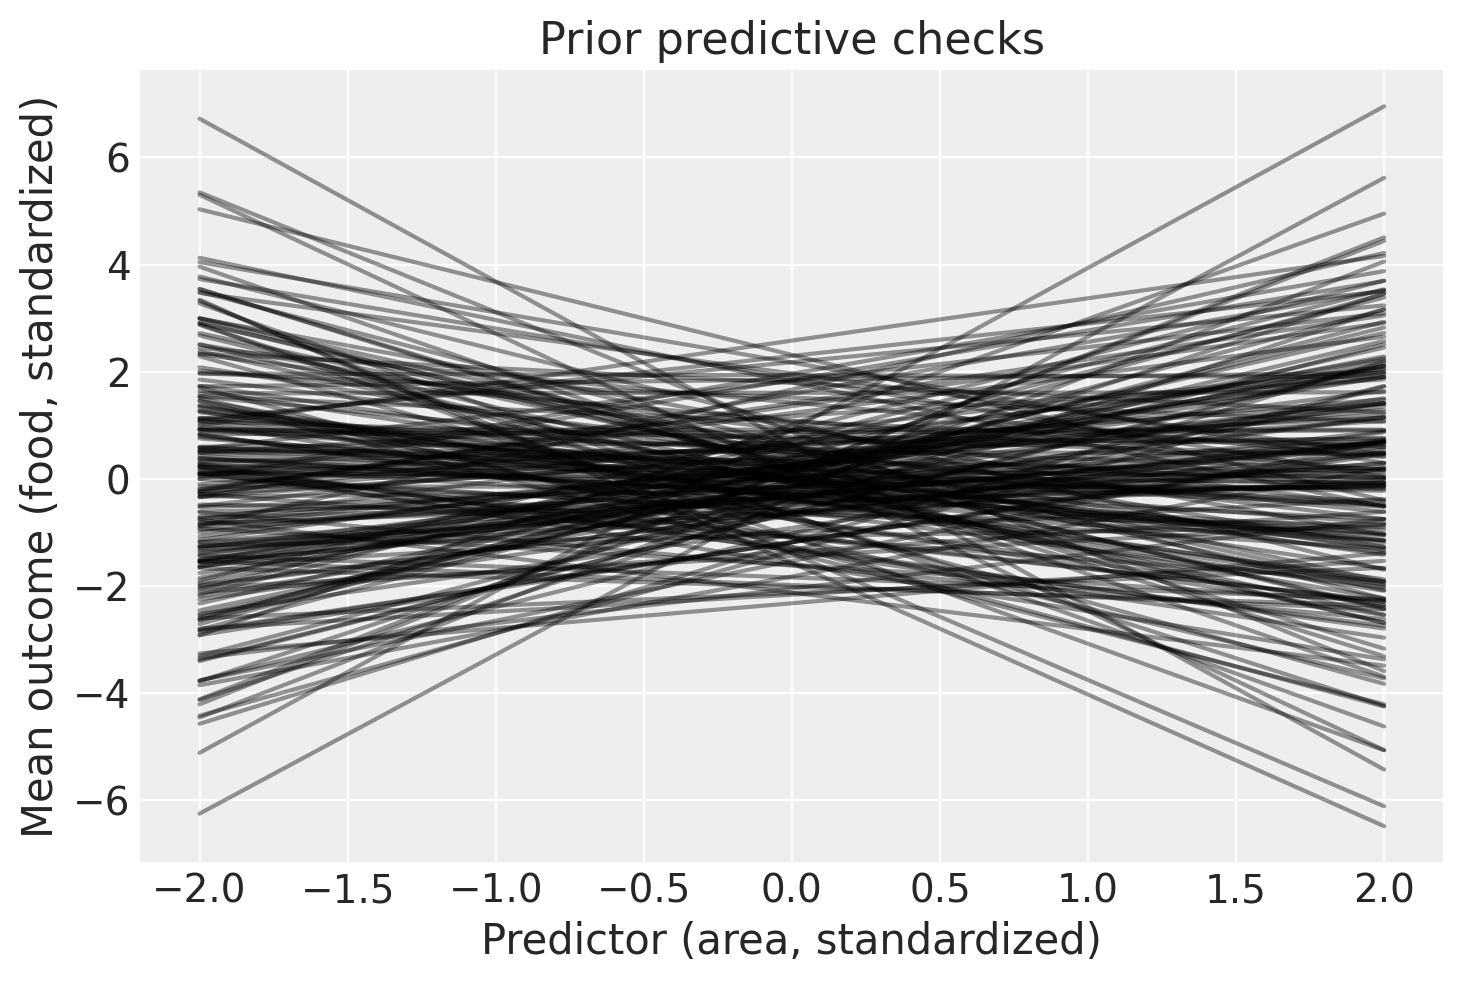

<IPython.core.display.Javascript object>

In [9]:
# prior checks
f, ax = plt.subplots()

x = np.linspace(-2, 2, 50)

for a, bA in zip(prior_checks["a"], prior_checks["bA"]):
    y = a + bA * x
    ax.plot(x, y, c="k", alpha=0.4)

ax.set_xlabel("Predictor (area, standardized)")
ax.set_ylabel("Mean outcome (food, standardized)")
ax.set_title("Prior predictive checks")

In [10]:
az.summary(idata_mq1)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.000,0.043,-0.071,0.066,0.001,0.001,6182.0,2059.0,6189.0,3041.0,1.0
bA,0.883,0.044,0.812,0.954,0.001,0.000,5462.0,5389.0,5483.0,3248.0,1.0
sigma,0.477,0.032,0.428,0.529,0.000,0.000,5613.0,5590.0,5564.0,2718.0,1.0


<IPython.core.display.Javascript object>

**This says that increasing the area by one standard deviation will produce about 0.882 standardized units of average food.**

In [11]:
x = np.linspace(df_foxes["avgfood_std"].min(), df_foxes["avgfood_std"].max(), 50)
x

array([-1.93317993, -1.84636271, -1.75954549, -1.67272828, -1.58591106,
       -1.49909384, -1.41227662, -1.32545941, -1.23864219, -1.15182497,
       -1.06500776, -0.97819054, -0.89137332, -0.80455611, -0.71773889,
       -0.63092167, -0.54410445, -0.45728724, -0.37047002, -0.2836528 ,
       -0.19683559, -0.11001837, -0.02320115,  0.06361606,  0.15043328,
        0.2372505 ,  0.32406772,  0.41088493,  0.49770215,  0.58451937,
        0.67133658,  0.7581538 ,  0.84497102,  0.93178823,  1.01860545,
        1.10542267,  1.19223989,  1.2790571 ,  1.36587432,  1.45269154,
        1.53950875,  1.62632597,  1.71314319,  1.7999604 ,  1.88677762,
        1.97359484,  2.06041205,  2.14722927,  2.23404649,  2.32086371])

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Posterior predictive checks')

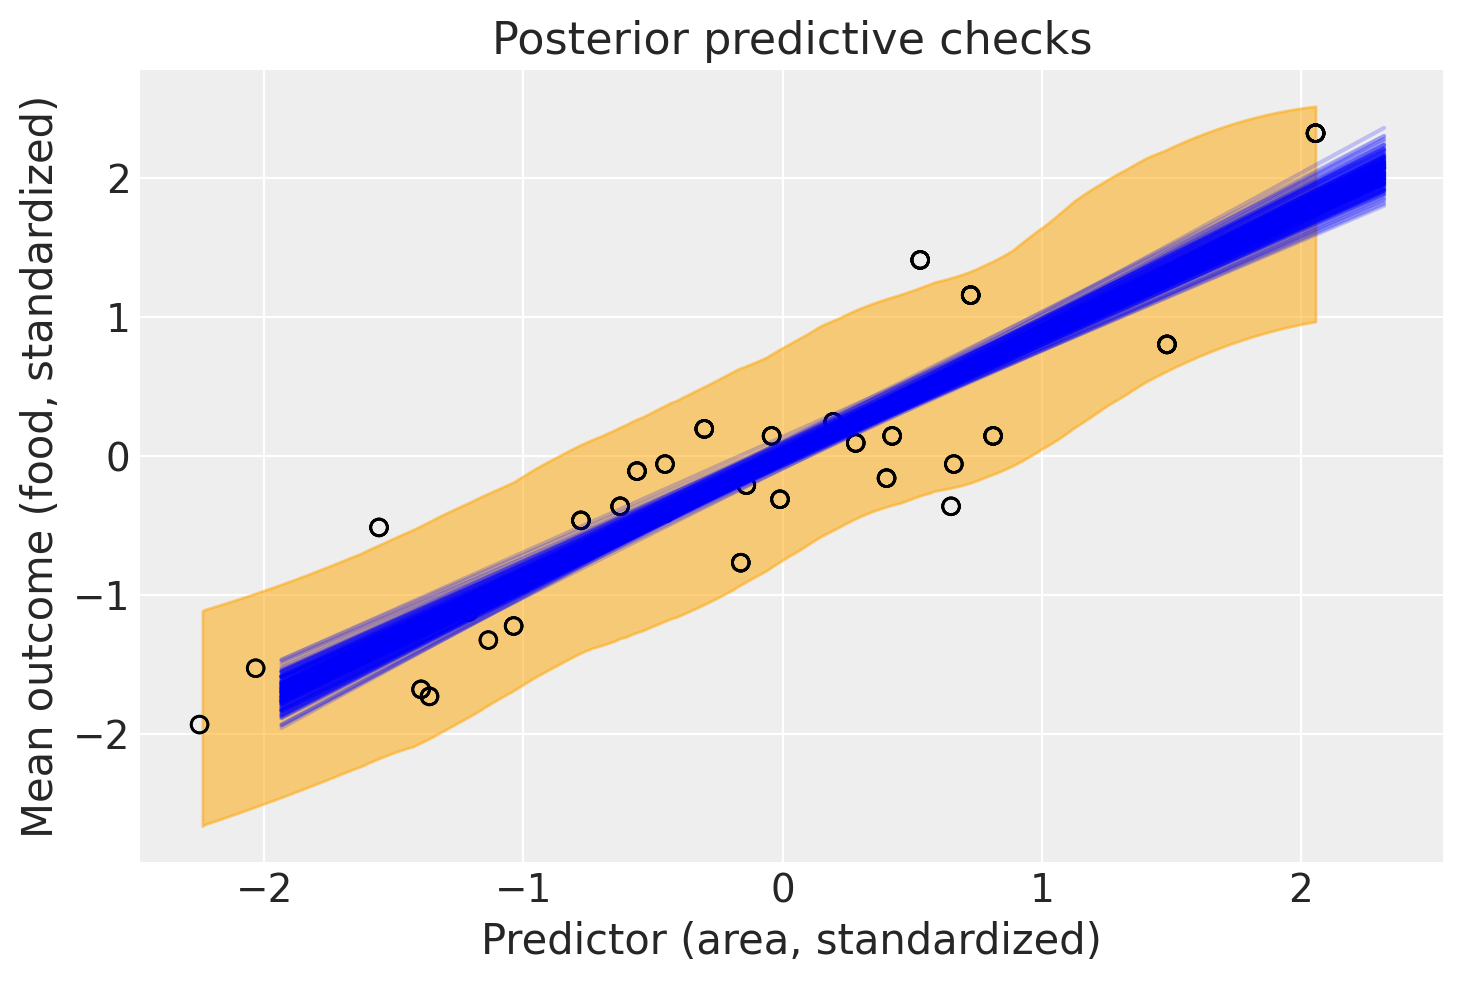

<IPython.core.display.Javascript object>

In [12]:
with mq1:
    posterior_checks = pm.sample_posterior_predictive(trace=idata_mq1, var_names=['a', 'bA', 'f'], samples=200)

# posterior checks
f, ax = plt.subplots()

# Plotting mean lines
x = np.linspace(df_foxes["avgfood_std"].min(), df_foxes["avgfood_std"].max(), 50)
for a, bA in zip(posterior_checks["a"], posterior_checks["bA"]):
    y = a + bA * x
    ax.plot(x, y, c="blue", alpha=0.2)

# Uncertainty around all predictions
az.plot_hdi(df_foxes["area_std"], posterior_checks["f"], color='orange', ax=ax)

# All raw data
ax.scatter(df_foxes["area_std"], df_foxes["avgfood_std"], facecolors='none', edgecolors='k')

ax.set_xlabel("Predictor (area, standardized)")
ax.set_ylabel("Mean outcome (food, standardized)")
ax.set_title("Posterior predictive checks")

In [13]:
# Make predictions using a function
def predict_sim(x, idata):
    
    # mean (easy to get)
    hi_mean = az.summary(idata).loc['a', 'mean'] + az.summary(idata).loc['bA', 'mean'] * x
    
    # make it accessible
    idata_df = idata.to_dataframe()

    # uncertainty requires thinking generatively
    mu_post_hi =idata_df[('posterior', 'a')] + idata_df[('posterior', 'bA')].mean() * x
    sigma_post_hi = idata_df[('posterior', 'sigma')]
    hpdi_89 = az.hdi(stats.norm.rvs(mu_post_hi, sigma_post_hi))

    return hi_mean, hpdi_89

<IPython.core.display.Javascript object>

Why are the posterior predicitions "squiggly"? It's just sampling variation. This is the line that samples.

`hpdi_89 = az.hdi(stats.norm.rvs(mu_post_hi, sigma_post_hi))`

In [14]:
az.summary(idata_mq1)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.000,0.043,-0.071,0.066,0.001,0.001,6182.0,2059.0,6189.0,3041.0,1.0
bA,0.883,0.044,0.812,0.954,0.001,0.000,5462.0,5389.0,5483.0,3248.0,1.0
sigma,0.477,0.032,0.428,0.529,0.000,0.000,5613.0,5590.0,5564.0,2718.0,1.0


<IPython.core.display.Javascript object>

# Q2

Now also analyze the “dislike” nominations. Estimate the amount of reciprocity
in the “dislike” nominations and compare to the estimate from the “like” nominations.
Does “like” or “dislike” have higher reciprocity? Be sure to compute the
posterior contrast between the two estimates.

## Answer


yyyyyyy


In [16]:
with pm.Model() as mq2a:

    # priors
    a = pm.Normal("a", 0, 1)
    bF = pm.Normal("bF", 0, 2)
    sigma = pm.Exponential("sigma", 1)

    # linear model
    mu = a + bF*df['avgfood_std']

    # likelihood
    W = pm.Normal("W", mu, sigma, observed=df_foxes['weight_std'])

    # posterior
    idata_mq2a = pm.sample(draws=1000, tune=1000, return_inferencedata=True, progressbar=False)

    # posterior predictions
    post_pred_mq2a = pm.sample_posterior_predictive(trace=idata_mq2a, samples=100)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bF, a]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'direct effect of food on weight')

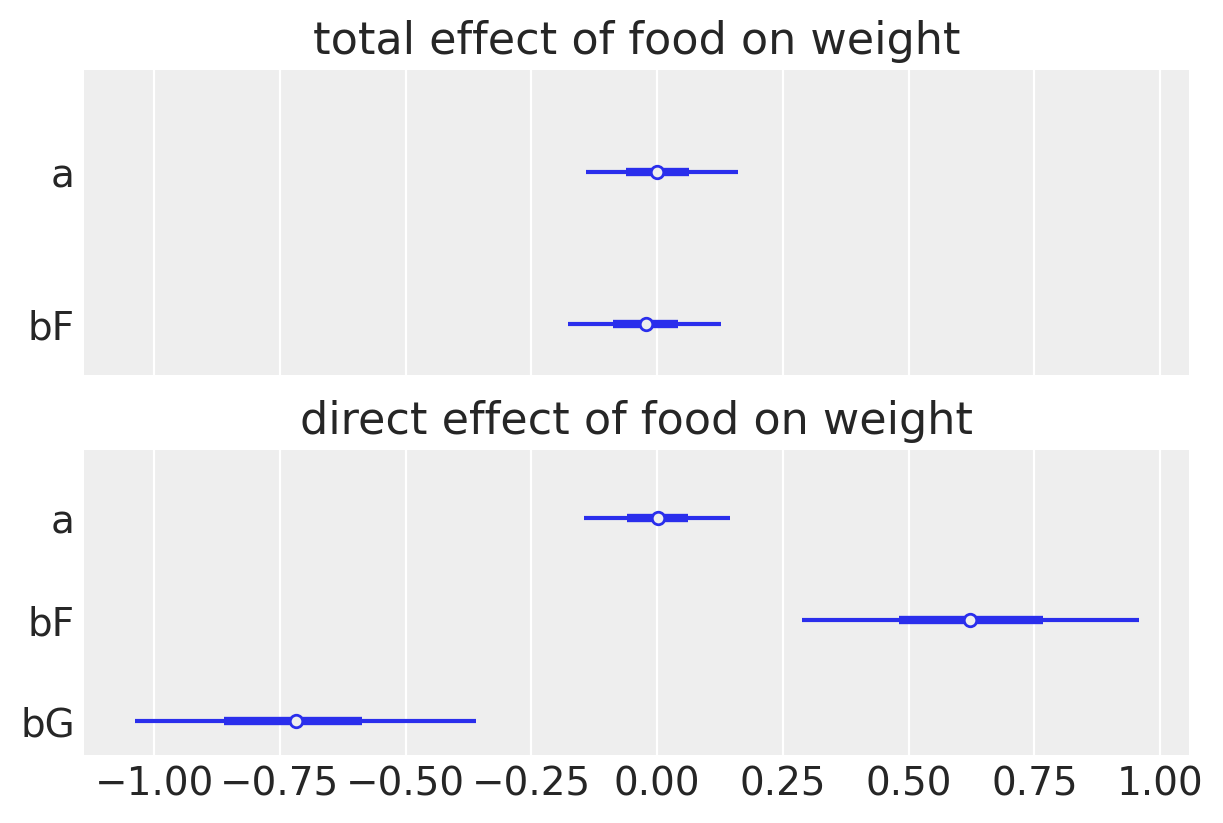

<IPython.core.display.Javascript object>

In [18]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 4), sharex=True)
az.plot_forest(idata_mq2a, var_names=['a', 'bF'], combined=True, ax=ax1)
ax1.set_title("total effect of food on weight")

az.plot_forest(idata_mq2b, var_names=['a', 'bF', 'bG'], combined=True, ax=ax2)
ax2.set_title("direct effect of food on weight")

It is clear from the direct effect model that food has a positive impact on weight. However, when looking at the total effect, it appears that the effect of food gets blunted by the size of the group. Being part of a group with more members means that the food gets divided up for an individual fox. This is an instance of masked association (?).

When considering area though (Q1), a bigger territory can increase the overall quantity of food for an individual fox, because it is not affected by group size (A has no arrows pointing into it from G).


In [19]:
df_foxes.head()

,group,avgfood,groupsize,area,weight,area_std,avgfood_std,groupsize_std,weight_std
0,1,0.37,2,1.09,5.02,-2.249313,-1.933180,-1.530701,0.415931
1,1,0.37,2,1.09,2.84,-2.249313,-1.933180,-1.530701,-1.433238
2,2,0.53,2,2.05,5.33,-1.210738,-1.122886,-1.530701,0.678887
3,2,0.53,2,2.05,6.07,-1.210738,-1.122886,-1.530701,1.306586
4,3,0.49,2,2.12,5.85,-1.135008,-1.325459,-1.530701,1.119973


<IPython.core.display.Javascript object>

In [20]:
# Look for masked relationship? 
# sns.pairplot(df_foxes[['avgfood_std', 'groupsize_std', 'weight_std']])
# food and groupsize look correlated, but neither have obvious correlation with weight

<IPython.core.display.Javascript object>

# Q3

Now consider generalized liking and disliking. Add generalized “receiving” parameters
to the model, analogous to receiving varying effects from the sharing example
in the book/lecture. (Each monk only named 3 likes and 3 dislikes each time,
so the amount of “giving” is fixed by design in these data.) Can you identify any
individuals who are particularly liked/disliked, independent of the dyadic relations?

yyyyyy

## Answer

Tables 

| Coefficient on Y  |  Interpretation |
| ---- | ------- |
| X | direct and total effect |
| S | confounded effect because U is a fork that acts on S and Y |
| A | confounded effect because of path opened by conditioning on S (originally closed due to collider created by U) |


It's helpful to look at the scenario *without* U (lecture example). 


# Q4 (optional)

xxxxx

## Answer

yyyyyyy

### Replicating lecture 6 example

Using lecture 6, slide 83 example. R code shown below

```
f <- function(n=100,bZX=1,bXY=1) {
Z <- rnorm(n)
X <- rnorm(n, bZX*Z )
Y <- rnorm(n, bXY*X )
bX <- coef( lm(Y ~ X) )['X']
bXZ <- coef( lm(Y ~ X + Z) )['X']
return( c(bX,bXZ) )
}
sim <- mcreplicate( 1e4 , f(n=50) , mc.cores=8 )
dens( sim[1,] , lwd=3 , xlab="posterior mean" )
dens( sim[2,] , lwd=3 , col=2 , add=TRUE )

```

# Lecture 15 code

In [382]:
DATA_DIR2 = '/Users/blacar/Documents/ds_projects/stats_rethinking/pymc3_ed_resources/resources/Rethinking_2/Data/'
df_kl = pd.read_csv(DATA_DIR2 + "KosterLeckie.csv", sep=",", header=0)
df_kl.head()

,hidA,hidB,did,giftsAB,giftsBA,offset,drel1,drel2,drel3,drel4,dlndist,dass,d0125
0,1,2,1,0,4,0.000,0,0,1,0,-2.790,0.000,0
1,1,3,2,6,31,-0.003,0,1,0,0,-2.817,0.044,0
2,1,4,3,2,5,-0.019,0,1,0,0,-1.886,0.025,0
3,1,5,4,4,2,0.000,0,1,0,0,-1.892,0.011,0
4,1,6,5,8,2,-0.003,1,0,0,0,-3.499,0.022,0


<IPython.core.display.Javascript object>

[Text(0.5, 0, 'A gives B'), Text(0, 0.5, 'B gives A')]

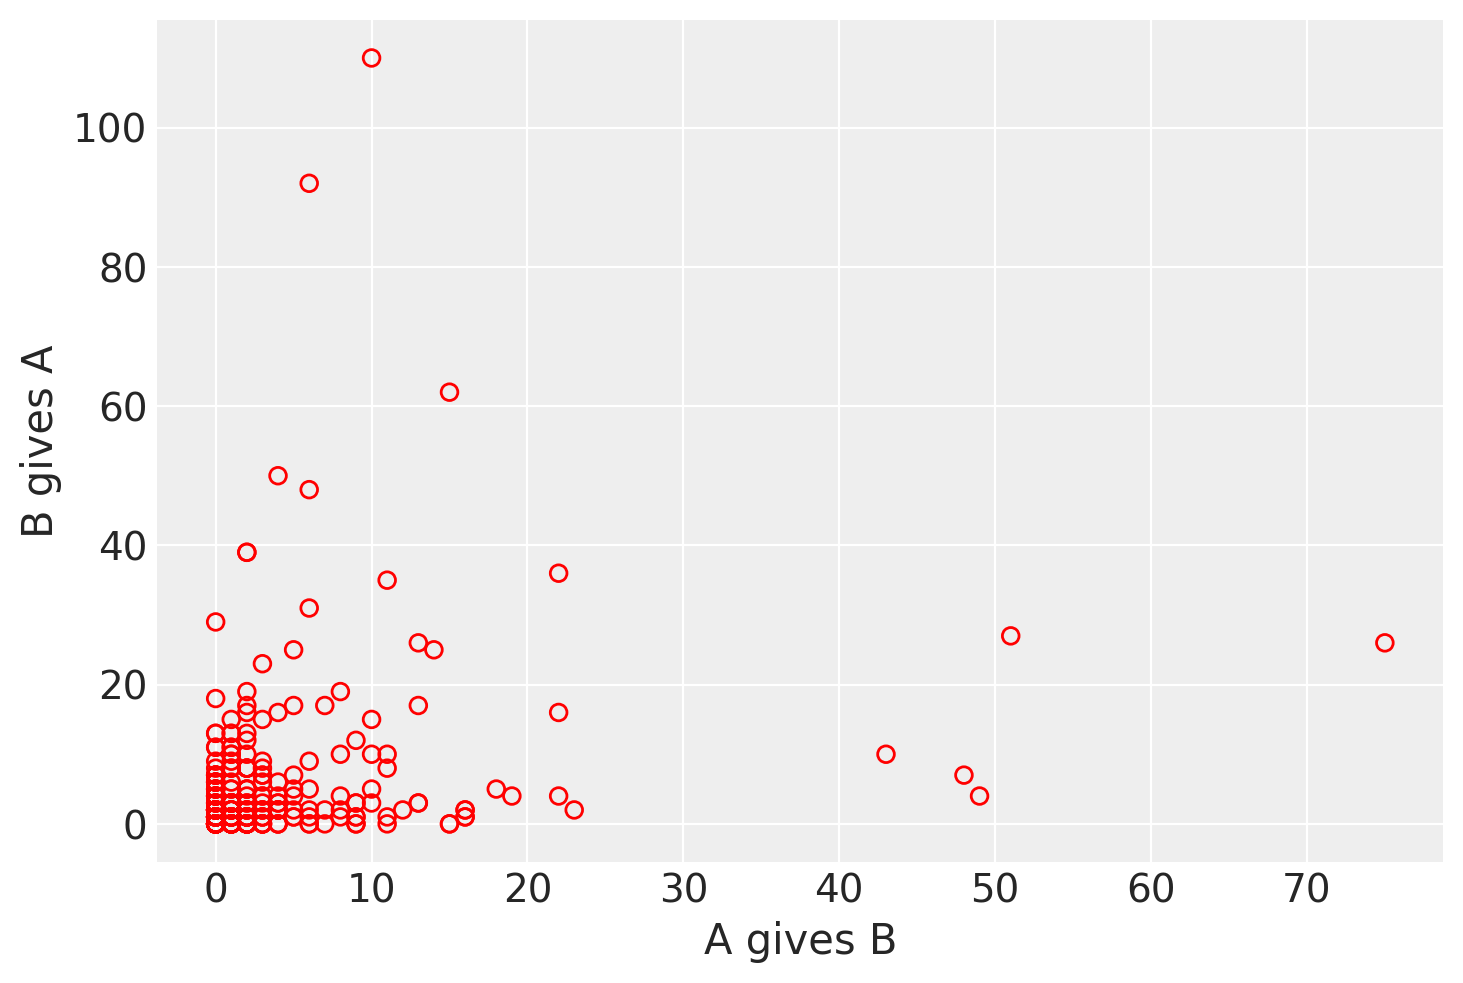

<IPython.core.display.Javascript object>

In [383]:
# slide 9

f, ax0 = plt.subplots()
ax0.scatter(df_kl['giftsAB'], df_kl['giftsBA'], facecolors='none', edgecolors='r')
ax0.set(xlabel='A gives B', ylabel='B gives A')

In [384]:
import itertools

<IPython.core.display.Javascript object>

In [385]:
dyads = list(itertools.combinations(range(N), 2))
np.array(itertools.combinations(range(N), 2))

array(<itertools.combinations object at 0x7f82d986fc20>, dtype=object)

<IPython.core.display.Javascript object>

In [386]:
# slide 27

# N households
N = 25
dyads = pd.DataFrame(list(itertools.combinations(range(N), 2)))
# dyads = np.array(list(itertools.combinations(range(N), 2)))
N_dyads = len(dyads)

# simulate "friendships" in which ties are shared
fr = stats.bernoulli.rvs(p=0.1, size=N_dyads)  # 10% of dyads are friends
# now simulate directed ties for all individuals
# there can be ties that are not reciprocal
alpha = -3 # base rate of ties; -3 ~= 0.05

# matrix of ties
y = np.zeros((N, N))
y[y==0] = None
for i in range(N):
    for j in range(N):
        if i != j:
            # directed tie from i to j
            ids = sorted([i, j])
            the_dyad = dyads[(dyads[0]==ids[0]) & (dyads[1]==ids[1])]
            p_tie = fr[the_dyad.index] + (1-fr[the_dyad.index])*expit(alpha)  # either they're friends or they get base rate of ties
            y[i,j] = stats.bernoulli.rvs(p = p_tie, size=1)

<IPython.core.display.Javascript object>

In [387]:
y

array([[nan,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0., nan,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0., nan,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0., nan,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., nan,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0., nan,  1.,  0.,  0.,  1.,  1.,  1.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  1.,  1., nan,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
      

<IPython.core.display.Javascript object>

In [409]:
# slide 28

# now simulate gifts
giftsAB = [None] * N_dyads
giftsBA = [None] * N_dyads

lamb = np.log([0.5,2]) # rates of giving for y=0,y=1

for i in range(N_dyads):
    A = dyads.loc[i,0]
    B = dyads.loc[i,1]
    giftsAB[i] = stats.poisson.rvs( mu = np.exp( lamb[int(y[A,B])] ))
    giftsBA[i] = stats.poisson.rvs( mu = np.exp( lamb[int(y[B,A])] ))


<IPython.core.display.Javascript object>

In [410]:
# View simulated giving results
df_dyads_sim = pd.concat(
    [
        dyads,
        pd.DataFrame
        (
            {
                'giftsAB':giftsAB,
                'giftsBA':giftsBA
                }
                )
                ], axis=1
                )

df_dyads_sim

,0,1,giftsAB,giftsBA
0,0,1,1,1
1,0,2,0,1
2,0,3,0,0
3,0,4,1,1
4,0,5,0,4
...,...,...,...,...
295,21,23,1,1
296,21,24,1,1
297,22,23,1,1
298,22,24,1,0


<IPython.core.display.Javascript object>

In [122]:
# !pip install igraph
# !pip install cairocffi

<IPython.core.display.Javascript object>

In [148]:
import igraph
import cairocffi
# import cairo

<IPython.core.display.Javascript object>

In [144]:
sng = igraph.Graph.Adjacency(y)
# lx = igraph.layout.nicely(sng)
layout = sng.layout(layout='auto')
layout

<Layout with 25 vertices and 2 dimensions>

<IPython.core.display.Javascript object>

In [390]:
# igraph.plot(sng, layout=layout)

<IPython.core.display.Javascript object>

In [391]:
from theano import tensor as tt

<IPython.core.display.Javascript object>

In [392]:
len(giftsBA)

300

<IPython.core.display.Javascript object>

In [393]:
dyads.index

RangeIndex(start=0, stop=300, step=1)

<IPython.core.display.Javascript object>

In [394]:
dyads.head()

,0,1
0,0,1
1,0,2
2,0,3
3,0,4
4,0,5


<IPython.core.display.Javascript object>

In [395]:
N, N_dyads

(25, 300)

<IPython.core.display.Javascript object>

## Attempts at slide 35

In [411]:
with pm.Model() as mGD_0:
   
    # centered paramaterization
    
    ## dyad effects
    sd_dist = pm.Exponential.dist(1.0)

    # LKJCholeskyCov is more efficient than LKJCorr
    chol, Rho_, sigma = pm.LKJCholeskyCov(
        "chol", n=2, eta=2, sd_dist=sd_dist, compute_corr=True
    )

    T = pm.MvNormal("T", mu=0.0, chol=chol, shape=(2, 2))

    alpha = pm.Normal("alpha", 0, 1)
    lambdaAB = pm.Deterministic("lambdaAB", pm.math.exp(alpha + T[dyads.index, 0]))
    lambdaBA = pm.Deterministic("lambdaBA", pm.math.exp(alpha + T[dyads.index, 1]))

    G_AB = pm.Poisson("G_AB", mu = lambdaAB, observed = df_dyads_sim['giftsAB'])
    G_BA = pm.Poisson("G_BA", mu = lambdaBA, observed = df_dyads_sim['giftsBA'])

    trace_mGD_0 = pm.sample(1000, tune=1000, return_inferencedata=False)

IndexError: index 2 is out of bounds for axis 0 with size 2

<IPython.core.display.Javascript object>

In [248]:
az.summary(trace_mGD_0, var_names='T')

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"T[0,0]",0.0,0.004,-0.007,0.006,0.0,0.0,643.0,84.0,277.0,263.0,1.11
"T[0,1]",0.0,0.005,-0.008,0.008,0.0,0.0,1996.0,75.0,903.0,582.0,1.22
"T[1,0]",-0.0,0.005,-0.007,0.008,0.0,0.0,542.0,102.0,399.0,527.0,1.09
"T[1,1]",-0.0,0.005,-0.009,0.008,0.0,0.0,2288.0,61.0,1409.0,477.0,1.18
"T[2,0]",-0.0,0.004,-0.006,0.007,0.0,0.0,663.0,63.0,478.0,311.0,1.13
...,...,...,...,...,...,...,...,...,...,...,...
"T[297,1]",0.0,0.005,-0.009,0.007,0.0,0.0,1793.0,97.0,1115.0,494.0,1.17
"T[298,0]",0.0,0.005,-0.007,0.007,0.0,0.0,534.0,58.0,440.0,190.0,1.11
"T[298,1]",-0.0,0.005,-0.009,0.007,0.0,0.0,1737.0,79.0,1299.0,556.0,1.16
"T[299,0]",0.0,0.005,-0.007,0.008,0.0,0.0,320.0,92.0,256.0,271.0,1.08


<IPython.core.display.Javascript object>

In [225]:
 t_col.split('__')[1].split('_')[1]

'1'

<IPython.core.display.Javascript object>

In [230]:
trace_mGD_df = pm.trace_to_dataframe(trace_mGD)
t_cols = [col for col in trace_mGD_df.columns if 't__' in col]

trace_mGD_df[t_cols].mean(axis=0)

t__0_0     -0.000456
t__0_1      0.000408
t__1_0     -0.000201
t__1_1      0.000327
t__2_0     -0.000242
              ...   
t__297_1    0.000227
t__298_0   -0.000169
t__298_1    0.000186
t__299_0   -0.000372
t__299_1    0.000274
Length: 600, dtype: float64

<IPython.core.display.Javascript object>

In [412]:
with pm.Model() as mGD_1:
    
    # non-centered paramaterization
    
    ## dyad effects
    sd_dist = pm.Exponential.dist(1.0)

    # LKJCholeskyCov is more efficient than LKJCorr
    chol, Rho_, sigma = pm.LKJCholeskyCov(
        "chol", n=2, eta=2, sd_dist=sd_dist, compute_corr=True
    )

    z = pm.Normal("z", 0.0, 1.0, shape=(2, N_dyads))
    T = pm.Deterministic("T", pm.math.dot(chol, z).T)

    # linear models
    alpha = pm.Normal("alpha", 0, 1)
    lambdaAB = pm.Deterministic("lambdaAB", pm.math.exp(alpha + T[dyads.index, 0]))
    lambdaBA = pm.Deterministic("lambdaBA", pm.math.exp(alpha + T[dyads.index, 1]))

    G_AB = pm.Poisson("G_AB", mu = lambdaAB, observed = df_dyads_sim['giftsAB'])
    G_BA = pm.Poisson("G_BA", mu = lambdaBA, observed = df_dyads_sim['giftsBA'])

    trace_mGD_1 = pm.sample(1000, tune=1000, return_inferencedata=False)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, z, chol]
INFO:pymc3:NUTS: [alpha, z, chol]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.


<IPython.core.display.Javascript object>

In [413]:
az.summary(trace_mGD_1, var_names='T')

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"T[0,0]",0.197,0.581,-0.686,1.166,0.008,0.009,5819.0,1944.0,5838.0,2830.0,1.0
"T[0,1]",0.190,0.581,-0.722,1.112,0.008,0.010,5552.0,1812.0,5564.0,2942.0,1.0
"T[1,0]",-0.154,0.597,-1.119,0.785,0.008,0.010,5403.0,1783.0,5526.0,2883.0,1.0
"T[1,1]",0.038,0.582,-0.885,0.975,0.008,0.011,5415.0,1486.0,5470.0,2725.0,1.0
"T[2,0]",-0.318,0.621,-1.357,0.616,0.008,0.010,5571.0,1994.0,5863.0,2601.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
"T[297,1]",0.182,0.559,-0.702,1.082,0.007,0.009,6018.0,2008.0,6091.0,2767.0,1.0
"T[298,0]",0.048,0.574,-0.788,1.034,0.008,0.010,5219.0,1501.0,5221.0,2580.0,1.0
"T[298,1]",-0.146,0.592,-1.026,0.868,0.009,0.011,4709.0,1573.0,4739.0,2560.0,1.0
"T[299,0]",-0.166,0.594,-1.112,0.765,0.007,0.011,6962.0,1527.0,7210.0,2509.0,1.0


<IPython.core.display.Javascript object>

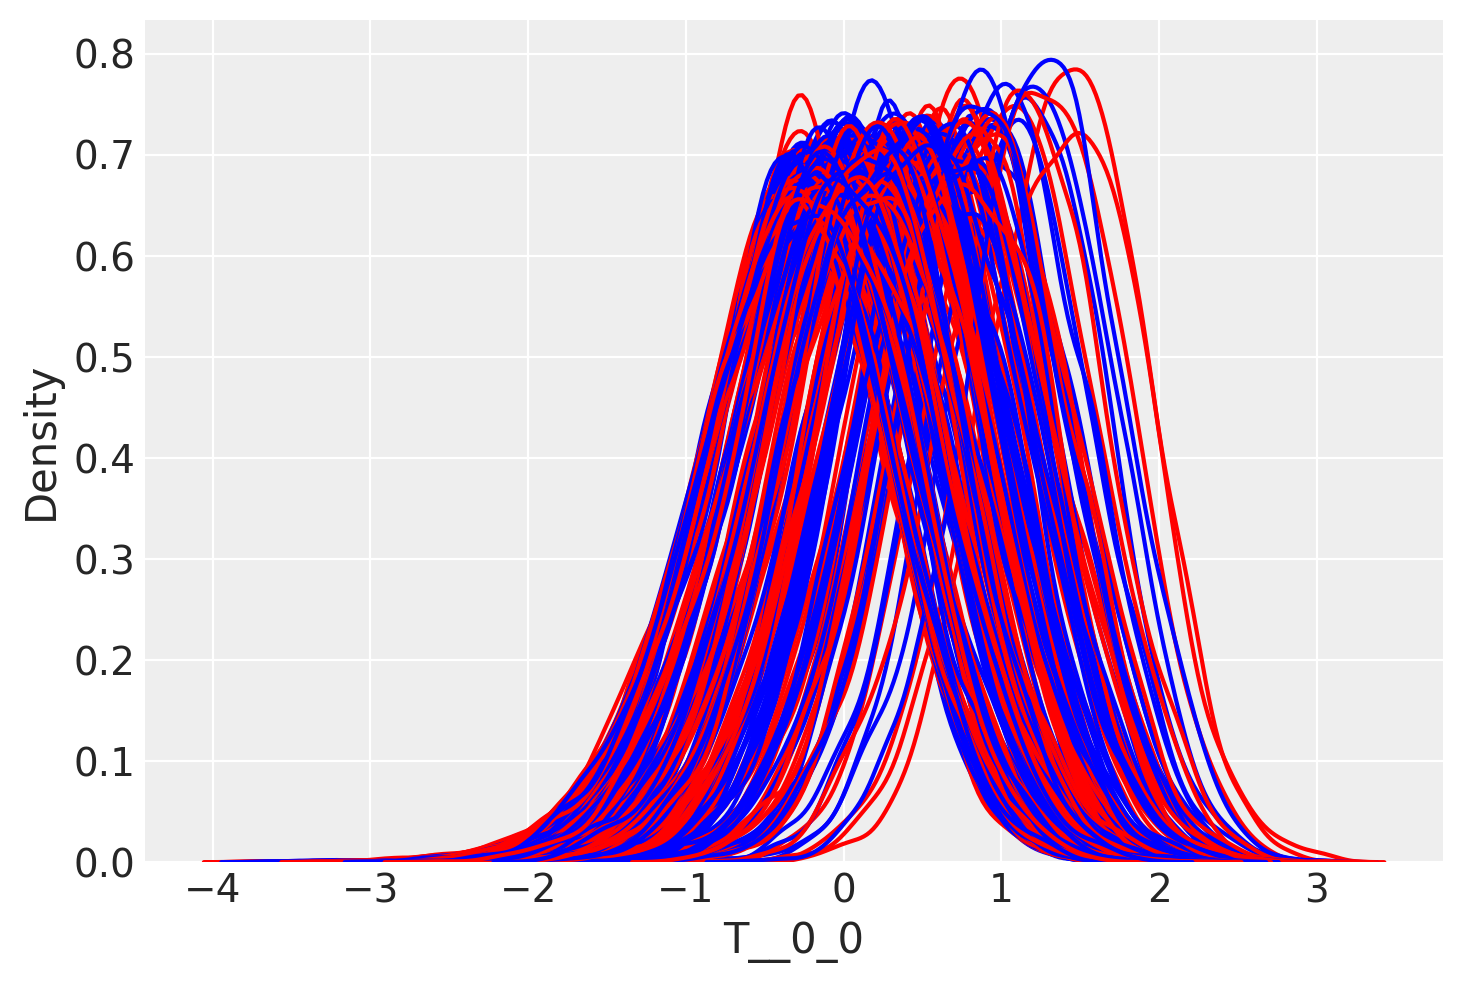

<IPython.core.display.Javascript object>

In [426]:
trace_mGD_1_df = pm.trace_to_dataframe(trace_mGD_1)
T_cols = [col for col in trace_mGD_1_df.columns if 'T__' in col]

T0_means = list()
T1_means = list()

f, ax0 = plt.subplots()
for T_col in T_cols:
    if T_col.split('T__')[1].split('_')[1] == str(0):
        sns.kdeplot(trace_mGD_1_df[T_col], ax=ax0, color='r', alpha=0.2)
        T0_means.append(trace_mGD_1_df[T_col].mean())
    if T_col.split('T__')[1].split('_')[1] == str(1):
        sns.kdeplot(trace_mGD_1_df[T_col], ax=ax0, color='b', alpha=0.2)
        T1_means.append(trace_mGD_1_df[T_col].mean())


In [438]:
T_est = pd.DataFrame({"TO":T0_means, "T1":T1_means})
T_est

,TO,T1
0,0.197038,0.190429
1,-0.153850,0.037663
2,-0.318290,-0.326785
3,0.185372,0.169605
4,0.238449,0.914441
...,...,...
295,0.188637,0.184785
296,0.195191,0.182626
297,0.182719,0.181940
298,0.048167,-0.146195


<IPython.core.display.Javascript object>

In [231]:
# convert to adjacency matrix
y_est = y.copy()
for i in range(N_dyads):
    y_est[ dyads.iloc[i,0] , dyads.iloc[i,1] ] = T_est.iloc[i,0]
    y_est[ dyads.iloc[i,1] , dyads.iloc[i,0] ] = T_est.iloc[i,1]

<IPython.core.display.Javascript object>

[Text(0.5, 0, 'correlation within dyads'),
 Text(0, 0.5, 'density'),
 Text(0.5, 1.0, 'unsure if this is right')]

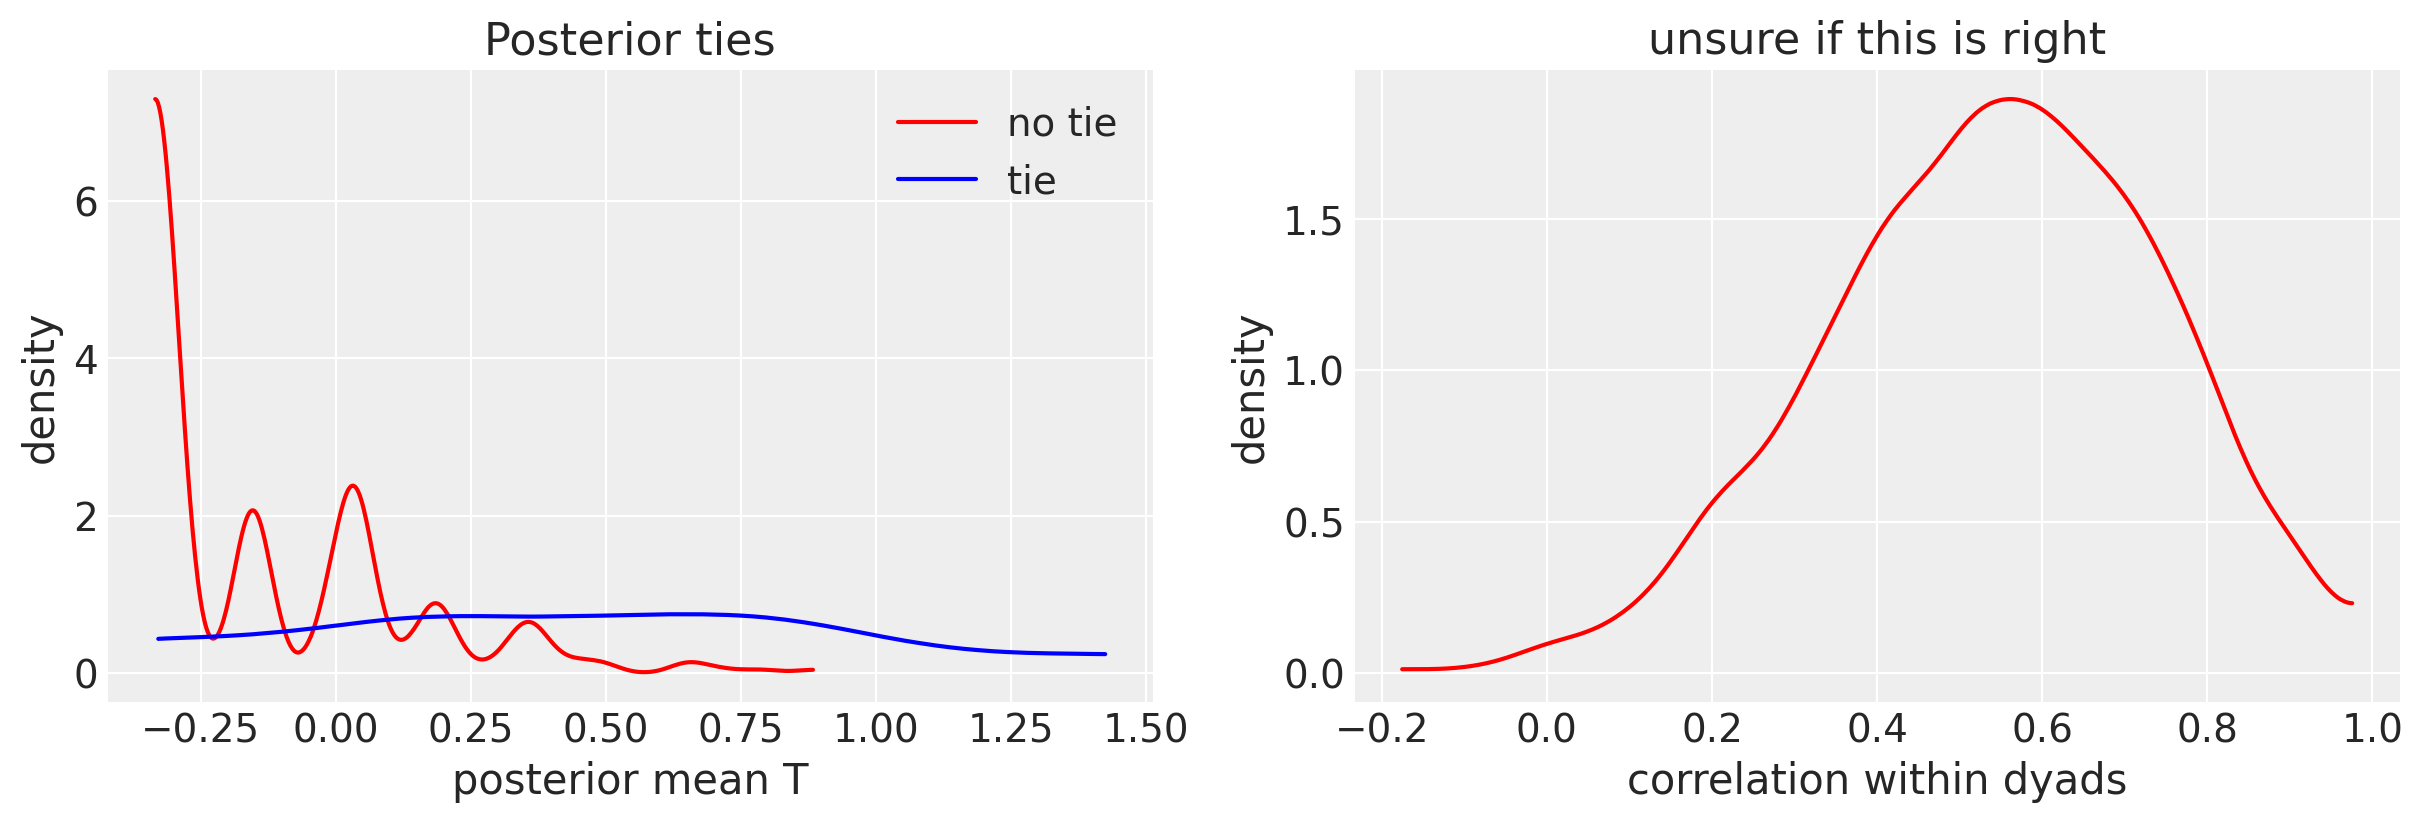

<IPython.core.display.Javascript object>

In [477]:
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 4))
az.plot_kde(y_est[y==0], label='no tie', plot_kwargs={"color": "red"}, ax=ax0)
az.plot_kde(y_est[y==1], label='tie', plot_kwargs={"color": "blue"}, ax=ax0)
ax0.legend()
ax0.set(xlabel='posterior mean T', ylabel='density', title='Posterior ties')

az.plot_kde(trace_mGD_1_df['chol_corr__0_1'], plot_kwargs={"color": "red"}, ax=ax1)
ax1.set(xlabel='correlation within dyads', ylabel='density', title='unsure if this is right')

In [466]:
[col for col in trace_mGD_1_df.columns if 'chol' in col]
# trace_mGD_1_df.columns 

['chol__0',
 'chol__1',
 'chol__2',
 'chol_stds__0',
 'chol_stds__1',
 'chol_corr__0_0',
 'chol_corr__0_1',
 'chol_corr__1_0',
 'chol_corr__1_1']

<IPython.core.display.Javascript object>

In [468]:
trace_mGD_1_df['chol_corr__1_0'].mean(), az.hdi(np.array(trace_mGD_1_df['chol_corr__1_0']))

(0.5367772681613076, array([0.20048785, 0.83959867]))

<IPython.core.display.Javascript object>

In [ ]:
trace_mGD_1_df['chol_corr__1_0']

In [465]:
# I believe chol[1] is supposed to be Rho
az.summary(trace_mGD_1, var_names='chol')

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
chol[0],0.677,0.102,0.518,0.841,0.003,0.002,1397.0,1397.0,1412.0,2286.0,1.0
chol[1],0.356,0.140,0.139,0.580,0.004,0.003,1390.0,1390.0,1386.0,2284.0,1.0
chol[2],0.541,0.133,0.325,0.751,0.004,0.003,1087.0,1087.0,1103.0,1523.0,1.0


<IPython.core.display.Javascript object>

In [216]:
az.summary(trace_mGD, var_names='lambdaAB')

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
lambdaAB[0],0.745,0.004,0.738,0.751,0.0,0.0,2706.0,2706.0,2470.0,2553.0,1.0
lambdaAB[1],0.745,0.004,0.738,0.751,0.0,0.0,2297.0,2296.0,2320.0,1284.0,1.0
lambdaAB[2],0.745,0.004,0.738,0.751,0.0,0.0,2779.0,2779.0,2713.0,2476.0,1.0
lambdaAB[3],0.745,0.004,0.738,0.752,0.0,0.0,2419.0,2419.0,2336.0,1768.0,1.0
lambdaAB[4],0.745,0.005,0.738,0.752,0.0,0.0,2130.0,2127.0,2091.0,1493.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
lambdaAB[295],0.745,0.004,0.739,0.752,0.0,0.0,1769.0,1761.0,1974.0,881.0,1.0
lambdaAB[296],0.745,0.005,0.738,0.752,0.0,0.0,2053.0,2044.0,2112.0,1167.0,1.0
lambdaAB[297],0.745,0.004,0.738,0.752,0.0,0.0,2993.0,2993.0,2766.0,2795.0,1.0
lambdaAB[298],0.745,0.005,0.738,0.751,0.0,0.0,1764.0,1764.0,1985.0,1089.0,1.0


<IPython.core.display.Javascript object>

In [172]:
trace_mGD_df = pm.trace_to_dataframe(trace_mGD)
trace_mGD_df.head()

,alpha,T__0,T__1,chol_cov__0,chol_cov__1,chol_cov__2,chol_cov_stds__0,chol_cov_stds__1,chol_cov_corr__0_0,chol_cov_corr__0_1,chol_cov_corr__1_0,chol_cov_corr__1_1,lamb_AB,lamb_BA
0,-0.600291,0.377045,0.219890,1.434177,0.084750,0.364995,1.434177,0.374705,1.0,0.226177,0.226177,1.0,0.799918,0.683588
1,-0.519915,0.211486,0.224318,0.203401,-0.048190,0.220053,0.203401,0.225268,1.0,-0.213922,-0.213922,1.0,0.734600,0.744087
2,-0.519915,0.211486,0.224318,0.203401,-0.048190,0.220053,0.203401,0.225268,1.0,-0.213922,-0.213922,1.0,0.734600,0.744087
3,-0.534191,0.201716,0.219187,0.212623,-0.038578,0.225837,0.212623,0.229109,1.0,-0.168384,-0.168384,1.0,0.717146,0.729785
4,-0.532723,0.254851,0.147047,0.268789,0.016630,0.320903,0.268789,0.321334,1.0,0.051754,0.051754,1.0,0.757393,0.679990


<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='T__0', ylabel='Density'>

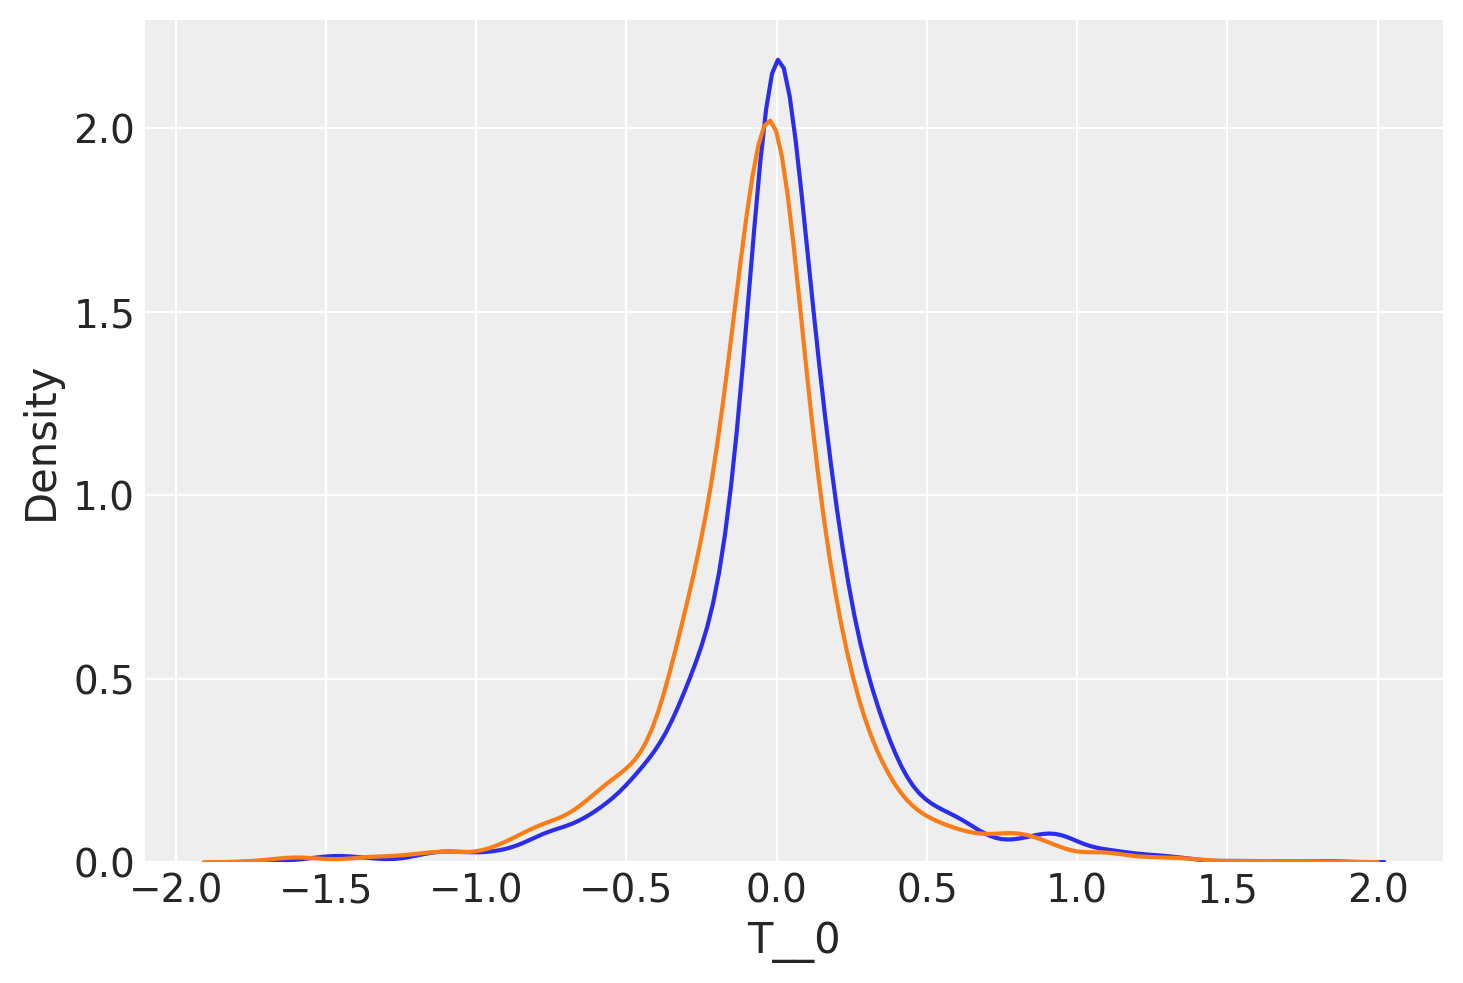

<IPython.core.display.Javascript object>

In [173]:
sns.kdeplot(trace_mGD_df['T__0'])
sns.kdeplot(trace_mGD_df['T__1'])

In [134]:
df_kl.head()

,hidA,hidB,did,giftsAB,giftsBA,offset,drel1,drel2,drel3,drel4,dlndist,dass,d0125
0,1,2,1,0,4,0.000,0,0,1,0,-2.790,0.000,0
1,1,3,2,6,31,-0.003,0,1,0,0,-2.817,0.044,0
2,1,4,3,2,5,-0.019,0,1,0,0,-1.886,0.025,0
3,1,5,4,4,2,0.000,0,1,0,0,-1.892,0.011,0
4,1,6,5,8,2,-0.003,1,0,0,0,-3.499,0.022,0


<IPython.core.display.Javascript object>

# Ch 14 code

## Cafe simulation

In [275]:
from matplotlib.patches import Ellipse, transforms

<IPython.core.display.Javascript object>

In [252]:
a = 3.5  # average morning wait time
b = -1.0  # average difference afternoon wait time
sigma_a = 1.0  # std dev in intercepts
sigma_b = 0.5  # std dev in slopes
rho = -0.7  # correlation between intercepts and slopes

Mu = [a, b]

<IPython.core.display.Javascript object>

In [253]:
cov_ab = sigma_a * sigma_b * rho
cov_ab

-0.35

<IPython.core.display.Javascript object>

In [256]:
# alternate equation
np.sqrt(sigma_a**2 * sigma_b**2) * rho

-0.35

<IPython.core.display.Javascript object>

In [257]:
Sigma = np.array([[sigma_a ** 2, cov_ab], [cov_ab, sigma_b ** 2]])
Sigma

array([[ 1.  , -0.35],
       [-0.35,  0.25]])

<IPython.core.display.Javascript object>

In [259]:
# way to generate matrix of variances and covariances, more translatable to later

# standard deviations
sigmas = [sigma_a, sigma_b]

# correlation matrix
Rho = np.matrix([[1, rho], [rho, 1]])

Rho

matrix([[ 1. , -0.7],
        [-0.7,  1. ]])

<IPython.core.display.Javascript object>

In [265]:
# matrix multiply to get covariance matrix

Sigma = np.diag(sigmas) * Rho * np.diag(sigmas)
Sigma

matrix([[ 1.  , -0.35],
        [-0.35,  0.25]])

<IPython.core.display.Javascript object>

In [280]:
np.diag(sigmas)

array([[1. , 0. ],
       [0. , 0.5]])

<IPython.core.display.Javascript object>

In [267]:
N_cafes = 20
vary_effects = stats.multivariate_normal.rvs(mean=Mu, cov=Sigma, size=N_cafes)
vary_effects

array([[ 3.97969989, -1.3761761 ],
       [ 4.83637502, -0.64591305],
       [ 3.21833317, -0.44326432],
       [ 4.42301342, -1.38722592],
       [ 1.77317993,  0.19911916],
       [ 3.11960758, -1.1683288 ],
       [ 2.53699619, -0.61661124],
       [ 3.1910247 , -0.85176869],
       [ 3.76240185, -1.17118632],
       [ 2.3501714 , -0.34617407],
       [ 2.99210156, -0.43384378],
       [ 4.59340051, -1.11472132],
       [ 1.91810201, -0.7057721 ],
       [ 2.61435724, -0.83981878],
       [ 2.23978085, -0.84222374],
       [ 4.9848839 , -1.68318727],
       [ 3.4643961 , -0.45849317],
       [ 3.88508512, -1.14167142],
       [ 3.3158583 , -0.94164532],
       [ 3.58370503, -1.50032734]])

<IPython.core.display.Javascript object>

In [272]:
a_cafe = vary_effects[:, 0]
b_cafe = vary_effects[:, 1]

<IPython.core.display.Javascript object>

[Text(0.5, 0, 'a'),
 Text(0, 0.5, 'b'),
 Text(0.5, 1.0, 'varying effects\n(samples from MV Gaussian)')]

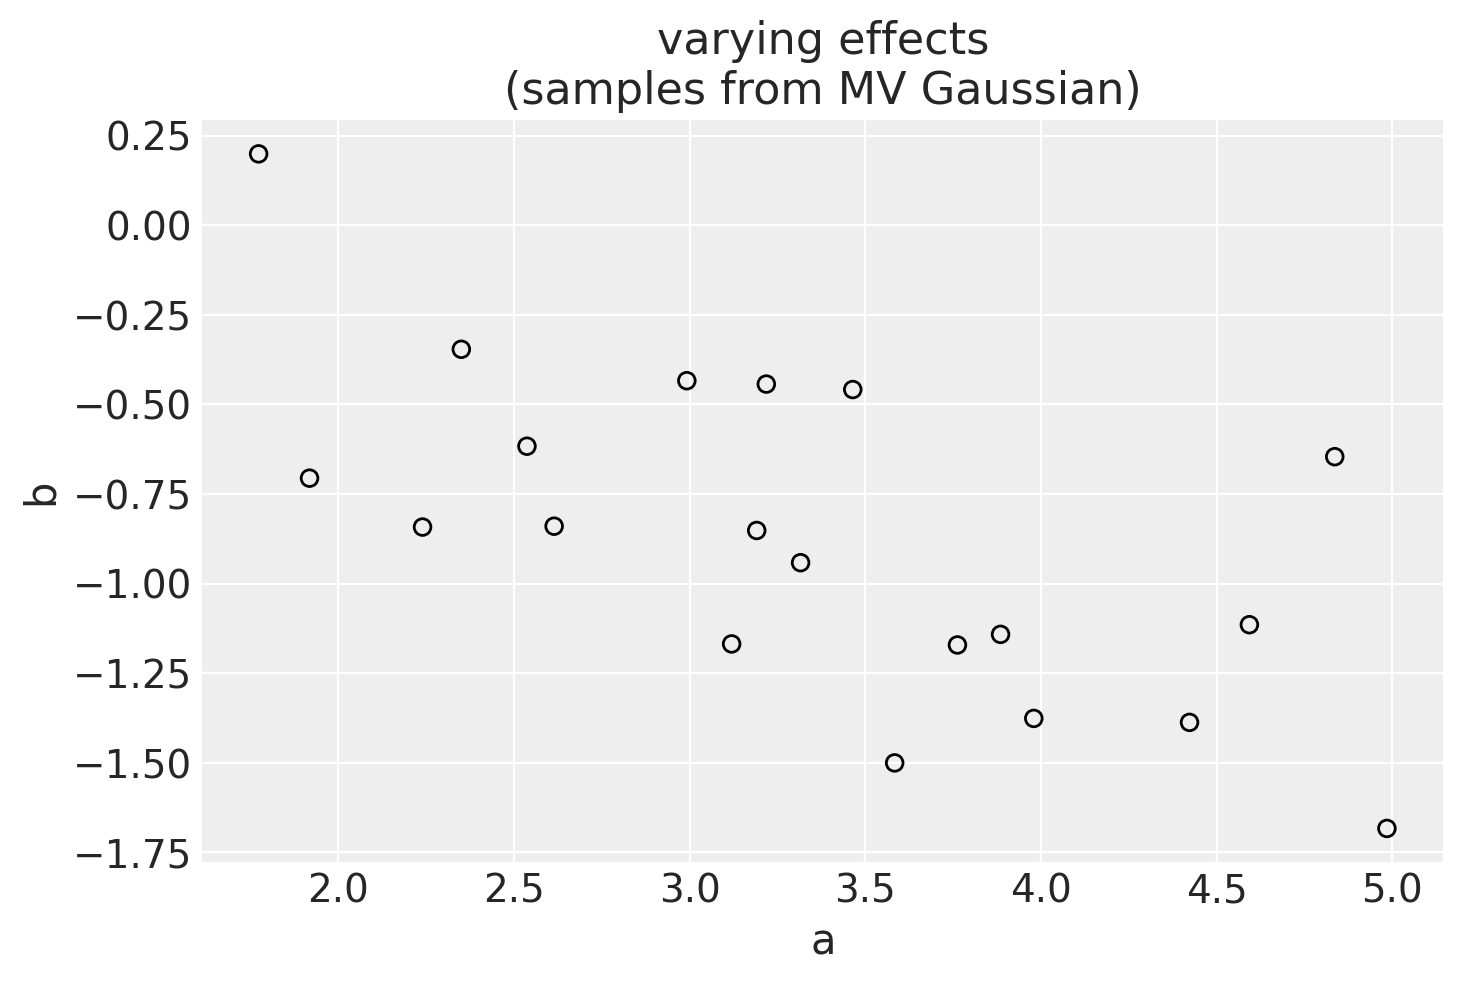

<IPython.core.display.Javascript object>

In [273]:
f, ax0 = plt.subplots()
ax0.scatter(a_cafe, b_cafe, facecolors='none', edgecolors='black')
ax0.set(xlabel='a', ylabel='b', title='varying effects\n(samples from MV Gaussian)')

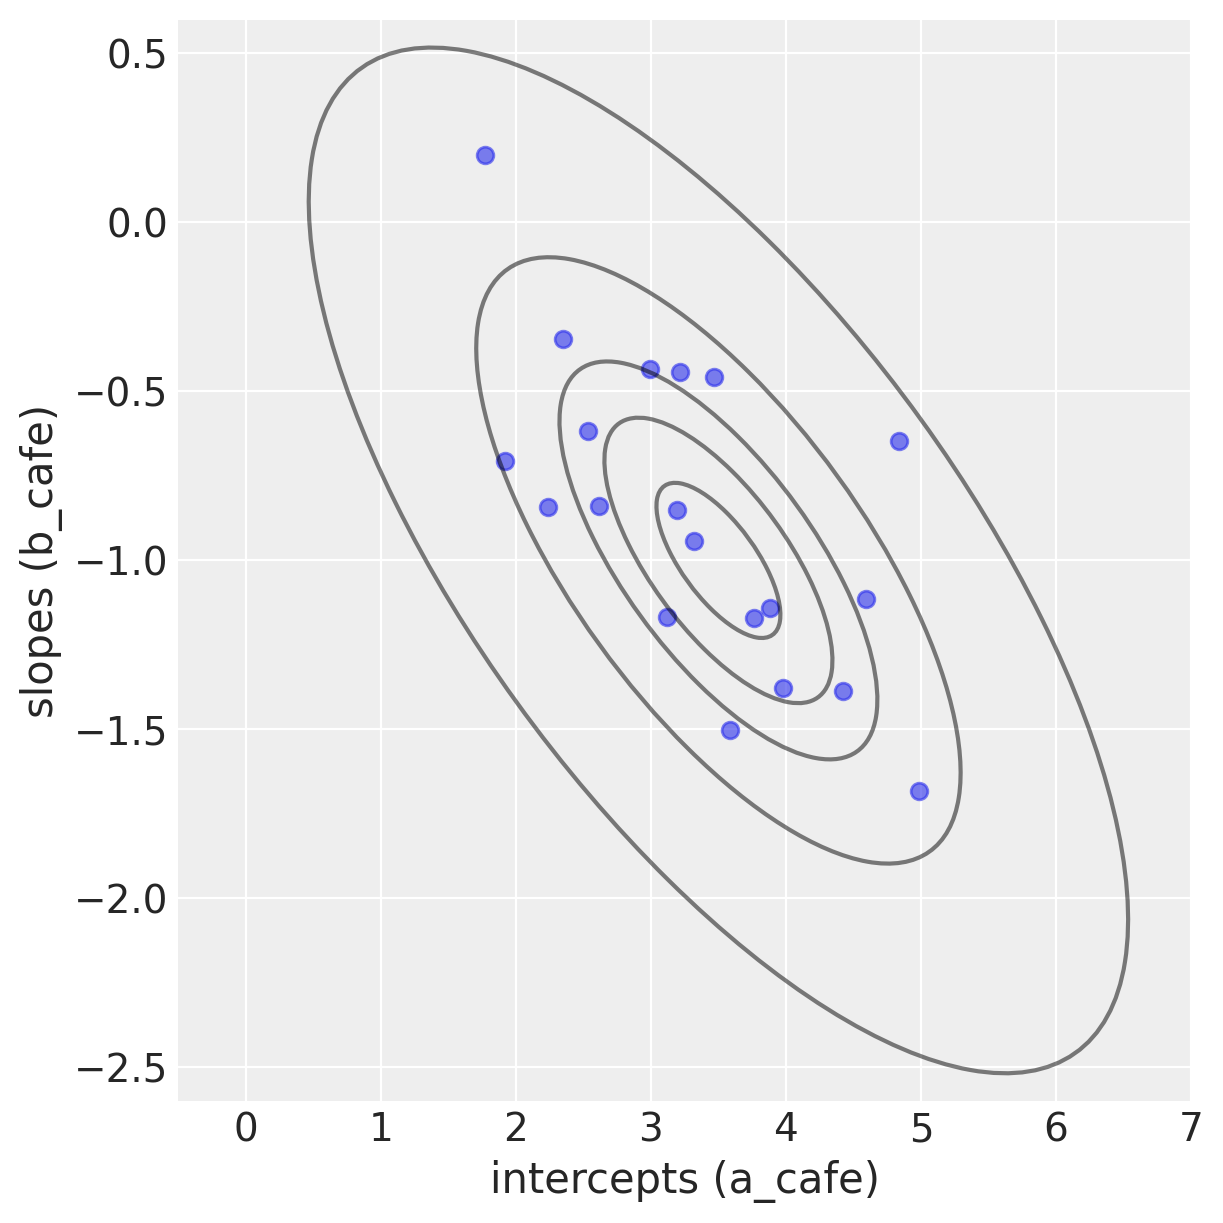

<IPython.core.display.Javascript object>

In [276]:
# repo code
def Gauss2d(mu, cov, ci, ax=None):
    """Copied from statsmodel"""
    if ax is None:
        _, ax = plt.subplots(figsize=(6, 6))

    v_, w = np.linalg.eigh(cov)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi  # convert to degrees

    for level in ci:
        v = 2 * np.sqrt(v_ * stats.chi2.ppf(level, 2))  # get size corresponding to level
        ell = Ellipse(
            mu[:2],
            v[0],
            v[1],
            180 + angle,
            facecolor="None",
            edgecolor="k",
            alpha=(1 - level) * 0.5,
            lw=1.5,
        )
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)

    return ax

ax = Gauss2d(Mu, np.asarray(Sigma), [0.1, 0.3, 0.5, 0.8, 0.99])
ax.scatter(a_cafe, b_cafe, alpha=0.6)
ax.set_xlim(-0.5, 7)
ax.set_ylim(-2.6, 0.6)
ax.set_xlabel("intercepts (a_cafe)")
ax.set_ylabel("slopes (b_cafe)");

In [277]:
# simulating observations

N_visits = 10
afternoon = np.tile([0, 1], N_visits * N_cafes // 2)  # wrap with int() to suppress warnings
cafe_id = np.repeat(np.arange(0, N_cafes), N_visits)  # 1-20 (minus 1 for python indexing)

mu = a_cafe[cafe_id] + b_cafe[cafe_id] * afternoon
sigma = 0.5  # std dev within cafes

wait = np.random.normal(loc=mu, scale=sigma, size=N_visits * N_cafes)
d = pd.DataFrame(dict(cafe=cafe_id, afternoon=afternoon, wait=wait))
d


,cafe,afternoon,wait
0,0,0,3.252189
1,0,1,1.468280
2,0,0,3.634038
3,0,1,2.496789
4,0,0,4.314220
...,...,...,...
195,19,1,2.593629
196,19,0,4.571482
197,19,1,1.829845
198,19,0,3.294634


<IPython.core.display.Javascript object>

## Cafe model

In [325]:
# rho values for 2x2 covariance matrix (smallest you can do)
pm.LKJCorr.dist(n=2, eta=2).random(size=5)

array([[ 0.09175872],
       [-0.33613891],
       [ 0.06960912],
       [-0.17980763],
       [-0.16761561]])

<IPython.core.display.Javascript object>

Where does the one unique value from each draw come from? The diagonal is 1, while the off-diagonals are symmetric.

```
[1  a]
[a  1]
```

In [326]:
# 5 draws of rho values for 3x3 covariance matrix
pm.LKJCorr.dist(n=3, eta=2).random(size=5)

array([[ 0.31095532,  0.50836646,  0.60144866],
       [-0.09085352, -0.07887157,  0.55693191],
       [ 0.31153606,  0.69180705,  0.11515487],
       [ 0.38565128, -0.86744224, -0.47563493],
       [ 0.40788775,  0.13697474,  0.08692137]])

<IPython.core.display.Javascript object>

Where do the three unique values from each draw come from? The diagonal is 1, while the off-diagonals are symmetric.
```
[1  a  b]
[a  1  c]
[b  c  1]
```

In [330]:
# 5 draws of rho values for 4x4 covariance matrix
pm.LKJCorr.dist(n=4, eta=2).random(size=5)

array([[-0.34284549, -0.6344284 , -0.27856606,  0.20122286,  0.37164713,
         0.64259971],
       [-0.12427067,  0.64729228,  0.01386816, -0.11262251,  0.46650347,
        -0.31784732],
       [ 0.00764113, -0.39143725, -0.4980444 ,  0.41459793, -0.44335174,
         0.56631983],
       [ 0.43485012, -0.23128761, -0.43212349,  0.44099402, -0.37625636,
        -0.37439256],
       [-0.6345009 ,  0.32015059,  0.1716239 , -0.39628061, -0.09057932,
         0.09725222]])

<IPython.core.display.Javascript object>

Where do the six unique values from each draw come from? The diagonal is 1, while the off-diagonals are symmetric.
```
[1  a  b  c]
[a  1  d  e]
[b  d  1  f]
[c  e  f  1]
```

You really only need the upper or lower triangle to get the values for each combination.

In [331]:
for rho_i in pm.LKJCorr.dist(n=2, eta=2).random(size=5):
    print(np.diag(rho_i))

[[-0.09499729]]
[[0.51519244]]
[[0.78151575]]
[[0.55276258]]
[[0.5204974]]


<IPython.core.display.Javascript object>

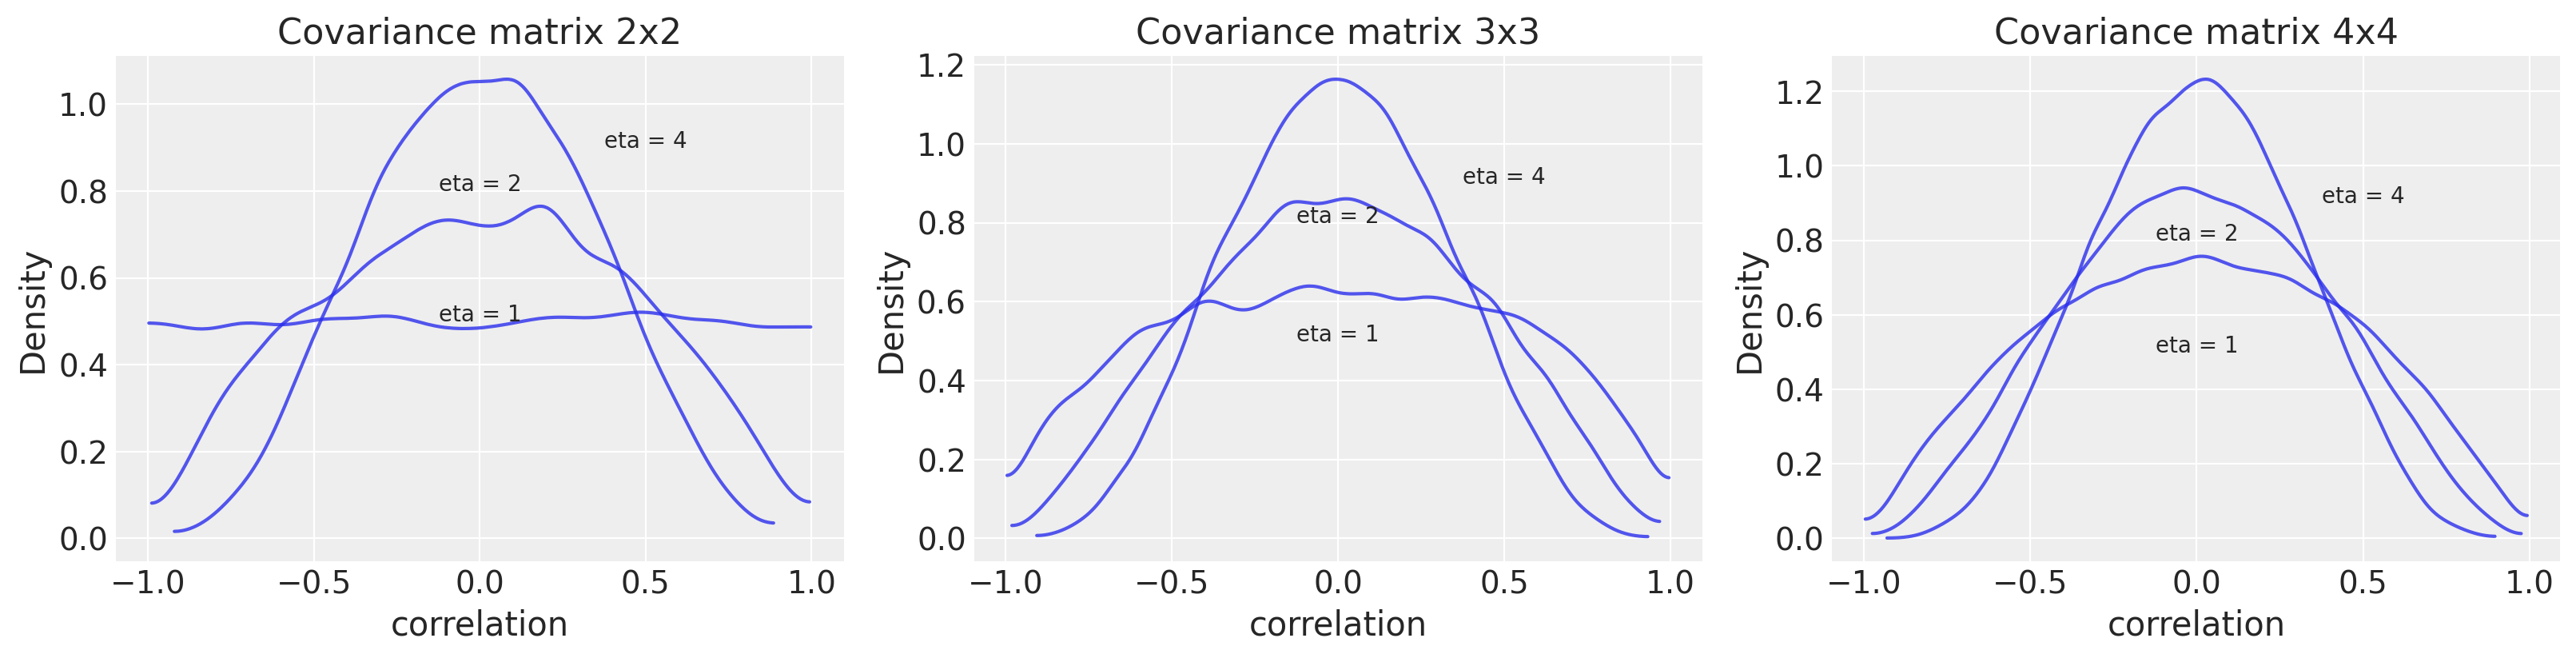

<IPython.core.display.Javascript object>

In [347]:
# repo code (for covariance matrix of 2x2)
f, ax = plt.subplots(1, 3, figsize=(16, 4))
textloc = [[0, 0.5], [0, 0.8], [0.5, 0.9]]

for i in range(3):
    for eta, loc in zip([1, 2, 4], textloc):
        R = pm.LKJCorr.dist(n=i+2, eta=eta).random(size=10000)
        az.plot_kde(R, plot_kwargs={"alpha": 0.8}, ax=ax[i])
        ax[i].text(loc[0], loc[1], "eta = %s" % (eta), horizontalalignment="center")

    ax[i].set_xlabel("correlation")
    ax[i].set_ylabel("Density")
    ax[i].set_title(f"Covariance matrix {i+2}x{i+2}");

In [346]:
R.shape

(10000, 6)

<IPython.core.display.Javascript object>

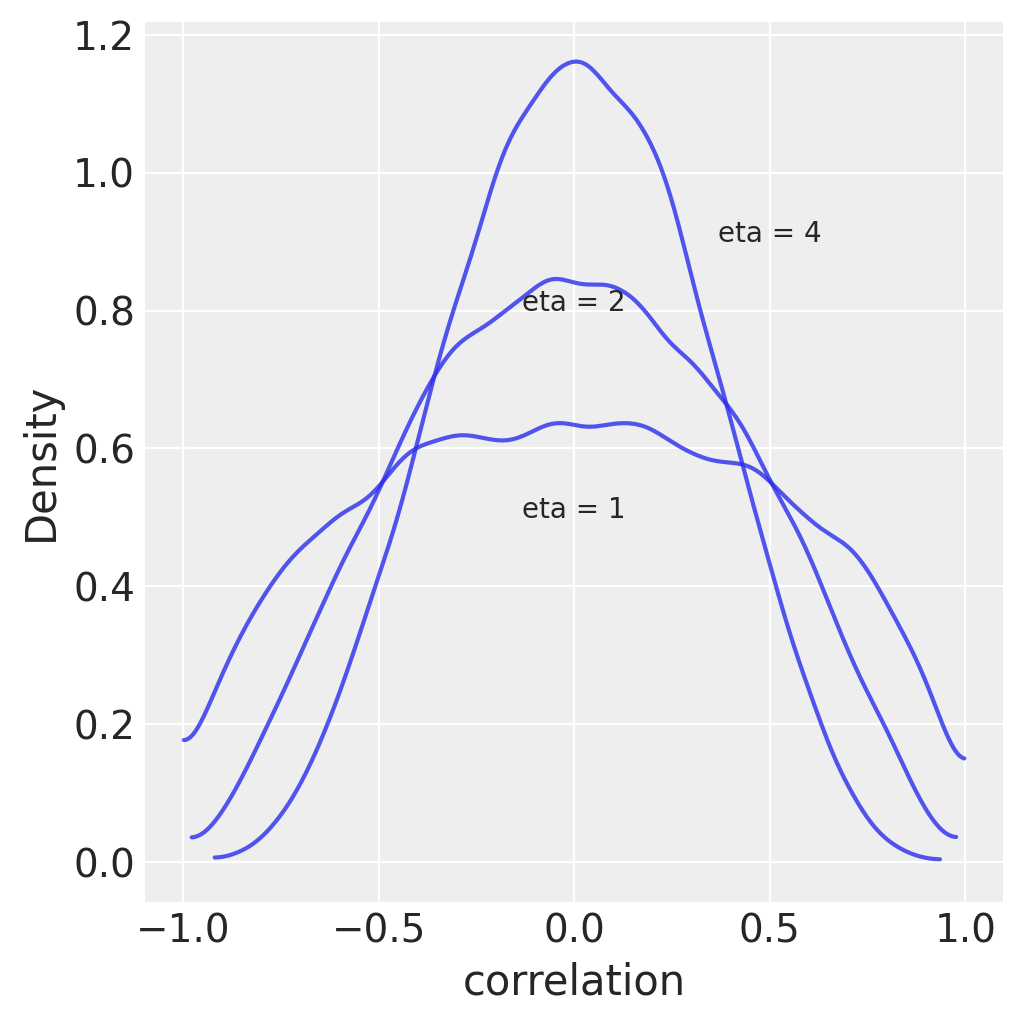

<IPython.core.display.Javascript object>

In [334]:
# repo code (for covariance matrix of 2x2)
_, ax = plt.subplots(1, 1, figsize=(5, 5))
textloc = [[0, 0.5], [0, 0.8], [0.5, 0.9]]

for eta, loc in zip([1, 2, 4], textloc):
    R = pm.LKJCorr.dist(n=3, eta=eta).random(size=10000)
    az.plot_kde(R, plot_kwargs={"alpha": 0.8})
    ax.text(loc[0], loc[1], "eta = %s" % (eta), horizontalalignment="center")

ax.set_xlabel("correlation")
ax.set_ylabel("Density");

`pm.LKJCorr` only returns sampled rho values. I think `LKJCholeskyCov` would return the covariance matrix?

In [348]:
with pm.Model() as bs:
    sd_dist = pm.HalfNormal.dist(sd=1)
    packed_chol = pm.LKJCholeskyCov('chol_cov', eta=2, n=2, sd_dist=sd_dist)
    trace_bs = pm.sample(draws = 5)

<IPython.core.display.Javascript object>

In [324]:
az.summary(trace_bs)

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
chol_cov[0],0.857,0.630,0.254,1.177,0.144,0.103,19.0,19.0,19.0,19.0,1.54
chol_cov[1],0.004,0.272,-0.345,0.319,0.062,0.045,19.0,19.0,19.0,19.0,1.32
chol_cov[2],0.592,0.400,0.156,1.224,0.091,0.065,19.0,19.0,19.0,19.0,1.47


<IPython.core.display.Javascript object>

Why are there three values for chol_cov?

1. cholesky factor
2. Rho
3. sigma

Per pymc documentation for SR: `pm.LKJCholeskyCov` "extracts the stds and matrix of correlations automatically for us"

In [349]:
# not sure why pm.LKJCholeskyCov.dist isn't working

sd_dist = pm.Exponential.dist(1.0)
#chol, Rho, sigma = 

# pm.LKJCholeskyCov.dist(
#         n=2, eta=2, sd_dist=sd_dist, compute_corr=True
#     ).random(size=1)


# pm.LKJCholeskyCov.dist(
# n=2, eta=2).random(size=1)

<IPython.core.display.Javascript object>

In [350]:
d

,cafe,afternoon,wait
0,0,0,3.252189
1,0,1,1.468280
2,0,0,3.634038
3,0,1,2.496789
4,0,0,4.314220
...,...,...,...
195,19,1,2.593629
196,19,0,4.571482
197,19,1,1.829845
198,19,0,3.294634


<IPython.core.display.Javascript object>

In [351]:
# repo code

cafe_idx = d["cafe"].values
with pm.Model() as m14_1:
    # LKJCholeskyCov is more efficient than LKJCorr
    # PyMC >= 3.9 extracts the stds and matrix of correlations automatically for us
    chol, Rho_, sigma_cafe = pm.LKJCholeskyCov(
        "chol_cov", n=2, eta=2, sd_dist=pm.Exponential.dist(1.0), compute_corr=True
    )

    a = pm.Normal("a", mu=5.0, sd=2.0)  # prior for average intercept
    b = pm.Normal("b", mu=-1.0, sd=0.5)  # prior for average slope
    ab_cafe = pm.MvNormal(
        "ab_cafe", mu=tt.stack([a, b]), chol=chol, shape=(N_cafes, 2)
    )  # population of varying effects
    # shape needs to be (N_cafes, 2) because we're getting back both a and b for each cafe

    mu = ab_cafe[cafe_idx, 0] + ab_cafe[cafe_idx, 1] * d["afternoon"].values  # linear model
    sigma_within = pm.Exponential("sigma_within", 1.0)  # prior stddev within cafes

    wait = pm.Normal("wait", mu=mu, sigma=sigma_within, observed=d["wait"].values)  # likelihood

    trace_14_1 = pm.sample(1000, tune=4000, target_accept=0.9)
    idata_14_1 = az.from_pymc3(
        trace_14_1,
        dims={"ab_cafe": ["cafe_nbr", "var_effect"]},
        coords={
            "chol_cov_stds_dim_0": ["intercepts", "slopes"],
            "var_effect": ["intercepts", "slopes"],
        },
    )
post = idata_14_1.posterior = idata_14_1.posterior.rename_vars(
    {"chol_cov_corr": "Rho", "chol_cov_stds": "sigma_cafe"}
)

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_within, ab_cafe, b, a, chol_cov]
INFO:pymc3:NUTS: [sigma_within, ab_cafe, b, a, chol_cov]


Sampling 4 chains for 4_000 tune and 1_000 draw iterations (16_000 + 4_000 draws total) took 130 seconds.
INFO:pymc3:Sampling 4 chains for 4_000 tune and 1_000 draw iterations (16_000 + 4_000 draws total) took 130 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.


<IPython.core.display.Javascript object>

In [363]:
# covariance matrix of first sample from posterior
np.array(post['Rho'][0][0])

array([[ 1.        , -0.41148928],
       [-0.41148928,  1.        ]])

<IPython.core.display.Javascript object>

In [364]:
# covariance matrix of second sample from posterior
np.array(post['Rho'][0][1])

array([[ 1.        , -0.43163574],
       [-0.43163574,  1.        ]])

<IPython.core.display.Javascript object>

In [368]:
post["Rho"]

<xarray.DataArray 'Rho' (chain: 4, draw: 1000, chol_cov_corr_dim_0: 2, chol_cov_corr_dim_1: 2)>
array([[[[ 1.        , -0.41148928],
         [-0.41148928,  1.        ]],

        [[ 1.        , -0.43163574],
         [-0.43163574,  1.        ]],

        [[ 1.        , -0.35055036],
         [-0.35055036,  1.        ]],

        ...,

        [[ 1.        , -0.41304448],
         [-0.41304448,  1.        ]],

        [[ 1.        , -0.66655569],
         [-0.66655569,  1.        ]],

        [[ 1.        , -0.66955971],
         [-0.66955971,  1.        ]]],

...

       [[[ 1.        , -0.61800304],
         [-0.61800304,  1.        ]],

        [[ 1.        , -0.20849683],
         [-0.20849683,  1.        ]],

        [[ 1.        , -0.11504697],
         [-0.11504697,  1.        ]],

        ...,

        [[ 1.        , -0.51994071],
         [-0.51994071,  1.        ]],

        [[ 1.        ,  0.10809393],
         [ 0.10809393,  1.        ]],

        [[ 1.        , -0.5882547 ],
         [-0.5882547 ,  1.        ]]]])
Coordinates:
  * chain                (chain) int64 0 1 2 3
  * draw                 (draw) int64 0 1 2 3 4 5 6 ... 994 995 996 997 998 999
  * chol_cov_corr_dim_0  (chol_cov_corr_dim_0) int64 0 1
  * chol_cov_corr_dim_1  (chol_cov_corr_dim_1) int64 0 1

<IPython.core.display.Javascript object>

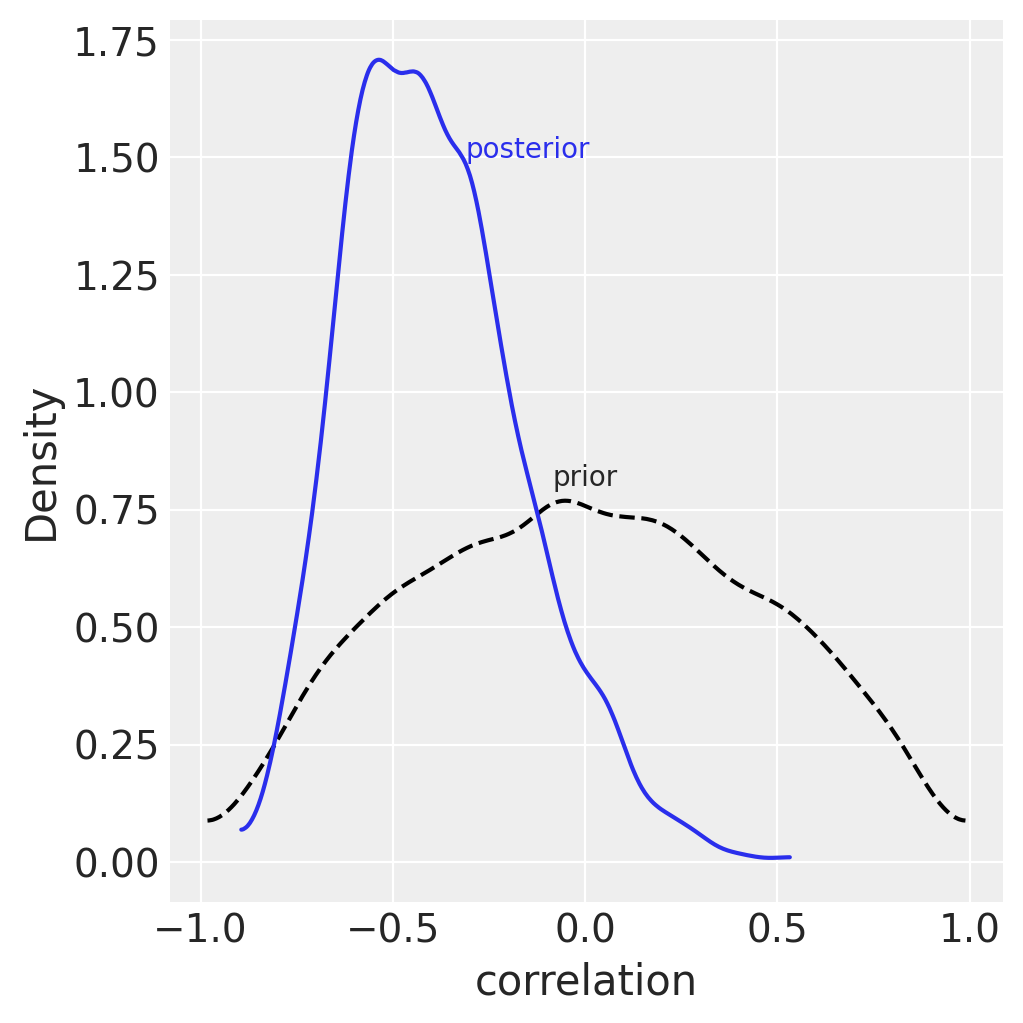

<IPython.core.display.Javascript object>

In [369]:
_, ax = plt.subplots(1, 1, figsize=(5, 5))

R = pm.LKJCorr.dist(n=2, eta=2).random(size=10000)
az.plot_kde(R, plot_kwargs={"color": "k", "linestyle": "--"})
ax.text(0, 0.8, "prior", horizontalalignment="center")

az.plot_kde(
    post["Rho"].sel(chol_cov_corr_dim_0=1, chol_cov_corr_dim_1=0),
    plot_kwargs={"color": "C0"},
)
ax.text(-0.15, 1.5, "posterior", color="C0", horizontalalignment="center")

ax.set_xlabel("correlation")
ax.set_ylabel("Density");

## Dyads book code

In [381]:
kl_dyads = df_kl.copy()
N = len(kl_dyads)
N_households = kl_dyads.hidB.max()
did = (kl_dyads.did - 1).values
hidA = (kl_dyads.hidA - 1).values
hidB = (kl_dyads.hidB - 1).values

<IPython.core.display.Javascript object>

In [374]:
did


array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

<IPython.core.display.Javascript object>

In [375]:
with pm.Model() as m14_7:
    ## gr matrix of varying effects
    sd_dist = pm.Exponential.dist(1.0)
    chol_gr, _, _ = pm.LKJCholeskyCov("chol_gr", n=2, eta=4, sd_dist=sd_dist, compute_corr=True)
    gr = pm.MvNormal("gr", mu=0.0, chol=chol_gr, shape=(N_households, 2))

    ## dyad effects
    chol_dyad, _, _ = pm.LKJCholeskyCov("chol_dyad", n=2, eta=8, sd_dist=sd_dist, compute_corr=True)
    z = pm.Normal("z", 0.0, 1.0, shape=(2, N))
    d = pm.Deterministic("d", pm.math.dot(chol_dyad, z).T)

    # linear models
    a = pm.Normal("a", mu=0.0, sd=1.0)
    lambdaAB = pm.math.exp(a + gr[hidA, 0] + gr[hidB, 1] + d[did, 0])
    lambdaBA = pm.math.exp(a + gr[hidB, 0] + gr[hidA, 1] + d[did, 1])

    giftsAB = pm.Poisson("giftsAB", lambdaAB, observed=kl_dyads.giftsAB)
    giftsBA = pm.Poisson("giftsBA", lambdaBA, observed=kl_dyads.giftsBA)

    trace_14_7 = pm.sample(2000, tune=3000, random_seed=RANDOM_SEED)
    idata_14_7 = az.from_pymc3(
        trace_14_7,
        dims={"d": ["Dyad", "House"], "gr": ["Household", "Rate"]},
        coords={"Rate": ["giving", "receiving"]},
    )
post_14_7 = idata_14_7.posterior = idata_14_7.posterior.rename_vars(
    {
        "chol_gr_corr": "Rho_gr",
        "chol_gr_stds": "sigma_gr",
        "chol_dyad_corr": "Rho_d",
        "chol_dyad_stds": "sigma_d",
    }
)

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, z, chol_dyad, gr, chol_gr]
INFO:pymc3:NUTS: [a, z, chol_dyad, gr, chol_gr]


Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 279 seconds.
INFO:pymc3:Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 279 seconds.
The number of effective samples is smaller than 25% for some parameters.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.


<IPython.core.display.Javascript object>

In [377]:
# az.summary(trace_14_7)

<IPython.core.display.Javascript object>

In [378]:
az.summary(idata_14_7, var_names=["Rho_gr", "sigma_gr"], round_to=2)

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/diagnostics.py:642: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"Rho_gr[0,0]",1.00,0.00,1.00,1.00,0.0,0.0,8000.00,8000.00,8000.00,8000.00,NaN
"Rho_gr[0,1]",-0.42,0.20,-0.73,-0.12,0.0,0.0,2853.60,2780.63,2781.46,4239.92,1.0
"Rho_gr[1,0]",-0.42,0.20,-0.73,-0.12,0.0,0.0,2853.60,2780.63,2781.46,4239.92,1.0
"Rho_gr[1,1]",1.00,0.00,1.00,1.00,0.0,0.0,8000.00,8000.00,8318.25,8000.00,1.0
sigma_gr[0],0.83,0.14,0.62,1.04,0.0,0.0,5087.16,4986.74,5283.08,5190.87,1.0
sigma_gr[1],0.41,0.09,0.27,0.55,0.0,0.0,1905.32,1905.32,1825.35,2711.64,1.0


<IPython.core.display.Javascript object>

In [380]:
g = (post_14_7["a"] + post_14_7["gr"].sel(Rate="giving")).stack(sample=("chain", "draw"))
r = (post_14_7["a"] + post_14_7["gr"].sel(Rate="receiving")).stack(sample=("chain", "draw"))
Eg_mu = np.exp(g).mean(dim="sample")
Er_mu = np.exp(r).mean(dim="sample")

<IPython.core.display.Javascript object>

Appendix: Environment and system parameters

In [33]:
%watermark -n -u -v -iv -w

Last updated: Wed Jan 26 2022

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.20.0

statsmodels: 0.12.2
scipy      : 1.6.0
pandas     : 1.2.1
arviz      : 0.11.1
daft       : 0.1.0
sys        : 3.8.6 | packaged by conda-forge | (default, Jan 25 2021, 23:22:12) 
[Clang 11.0.1 ]
numpy      : 1.20.1
matplotlib : 3.3.4
pymc3      : 3.11.0
seaborn    : 0.11.1

Watermark: 2.1.0



<IPython.core.display.Javascript object>